In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import category_encoders as ce

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv
/kaggle/input/countries/.xml


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн
countries_guide = pd.read_xml('/kaggle/input/countries/.xml')  # Справочник стран

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Преобразуем текстовые признаки

In [13]:
#выделим названия стран
def get_countries(country):
    adress_list = country.split(' ')
    if adress_list[-1] == 'Kingdom':
        countries = adress_list[-2]+' '+ adress_list[-1]
    else: countries = adress_list[-1]
    return countries

data['country'] = data['hotel_address'].apply(get_countries)

 #Проверим все ли значения являются названиями стран.
country_list = countries_guide['english'].to_list()
data['country'] = data['country'].apply(lambda x: x if x in country_list else '')
data['country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

In [14]:
#Закодируем названия стран
encoder = ce.OneHotEncoder(cols=['country']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)

In [15]:
#Добавим столбец в список для удаления
data_drop = ['country']


In [16]:
#выделим названия городов
def get_cities(city):
    adress_list = city.split(' ')
    cities = adress_list[-2]
    return cities
data['city'] = data['hotel_address'].apply(get_cities)
data['city'].value_counts()

United       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

In [17]:
# Исправим название Лондона
data['city'] = data['city'].apply(lambda x: 'London' if x == 'United' else x)
data['city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

In [18]:
#Закодируем названия городов
encoder = ce.OneHotEncoder(cols=['city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['city'])
data = pd.concat([data, type_bin], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [19]:
# Заполним пропуски медианной соответствующему городу
data_lat_lng = data.copy()
City = data_lat_lng.groupby(['city'])
City.lat.median()
City.lng.median()
data_lat_lng.lat = City.lat.apply(lambda x: x.fillna(x.median()))
data_lat_lng.lng = City.lng.apply(lambda x: x.fillna(x.median()))
data = data_lat_lng
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [20]:
#Добавим столбец с названием города в список для удаления
data_drop.append('city')

# Поскольку каждая страна предоставлена одним городом, посмотрим распределение оценок по странам

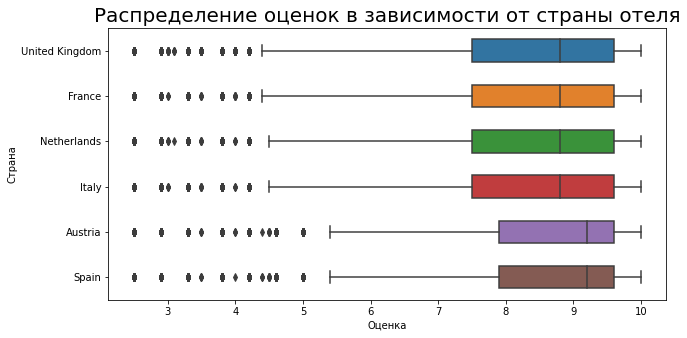

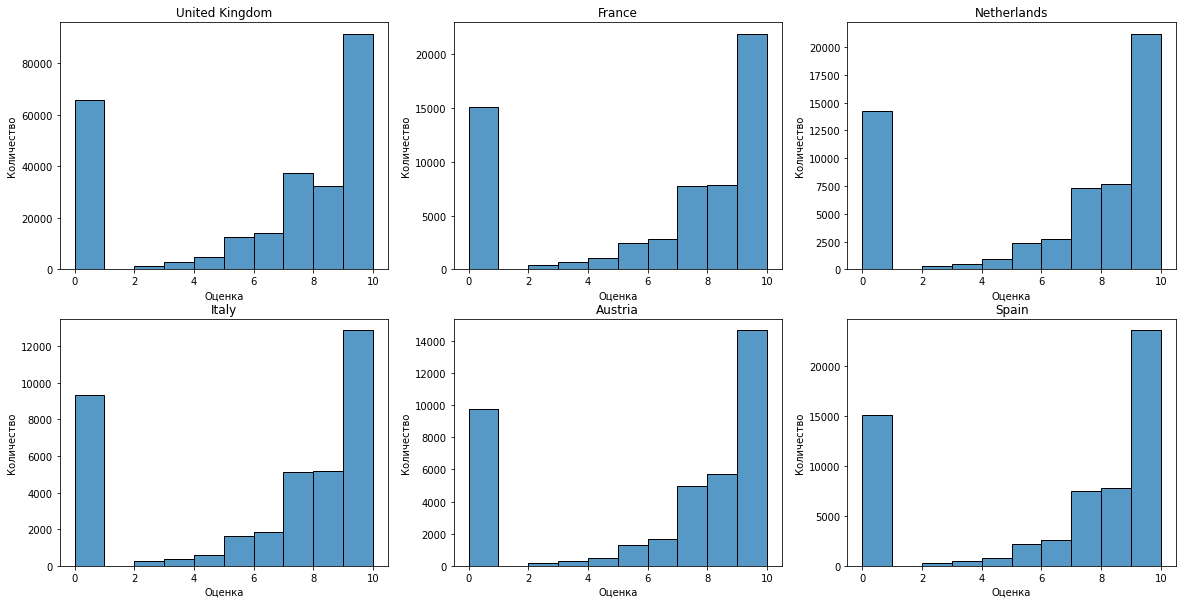

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
boxplot = sns.boxplot(
    data = data[data['sample'] == 1],
    y = 'country',
    x = 'reviewer_score',
    orient ='h',
    width = 0.5,
   )
boxplot.set_title('Распределение оценок в зависимости от страны отеля', size = 20);
boxplot.set_xlabel('Оценка');
boxplot.set_ylabel('Страна');

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Для Великобритании
histplot = sns.histplot(
    data = data[data['country'] == 'United Kingdom'],
    x = 'reviewer_score',
    bins=10,   
    ax=axes[0,0]   
)
histplot.set_title('United Kingdom');
histplot.set_xlabel('Оценка');
histplot.set_ylabel('Количество');

# Для Франции
histplot = sns.histplot(
    data = data[data['country'] == 'France'],
    x = 'reviewer_score',
    bins=10,   
    ax=axes[0,1]   
)
histplot.set_title('France');
histplot.set_xlabel('Оценка');
histplot.set_ylabel('Количество');

# Для Голандии
histplot = sns.histplot(
    data = data[data['country'] == 'Netherlands'],
    x = 'reviewer_score',
    bins=10,   
    ax=axes[0,2]   
)
histplot.set_title('Netherlands');
histplot.set_xlabel('Оценка');
histplot.set_ylabel('Количество');

# Для Италии
histplot = sns.histplot(
    data = data[data['country'] == 'Italy'],
    x = 'reviewer_score',
    bins=10,   
    ax=axes[1,0]   
)
histplot.set_title('Italy');
histplot.set_xlabel('Оценка');
histplot.set_ylabel('Количество');

# Для Австрии
histplot = sns.histplot(
    data = data[data['country'] == 'Austria'],
    x = 'reviewer_score',
    bins=10,   
    ax=axes[1,1]   
)
histplot.set_title('Austria');
histplot.set_xlabel('Оценка');
histplot.set_ylabel('Количество');

# Для Испании
histplot = sns.histplot(
    data = data[data['country'] == 'Spain'],
    x = 'reviewer_score',
    bins=10,   
    ax=axes[1,2]   
)
histplot.set_title('Spain');
histplot.set_xlabel('Оценка');
histplot.set_ylabel('Количество');

Для всех стран наблюдается одинаковая картина: наибольшее количество оценок расположено в диапазоне от 8,5 до 9,5. При этом у Испании и Австрии медиана выше, чем у остальных стран. Большая доля туристов не оставили оценку, это может исказить итоговую оценку. Большая часть туристов поставили высший бал отелям.

# Определим растояние от отеля до центра города

In [22]:
import geopy.distance

# для формирования нового признака используются координаты центра каждого города 

centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ],
    columns= ['country', 'city', 'center_lat', 'center_lng']
).set_index('country')

#функция вычисления до центра города по координатам
def get_dist_to_center(country, lng, lat):
   
    center_lat = centers['center_lat'][country]
    center_lng = centers['center_lng'][country]

    return geopy.distance.geodesic([center_lng, center_lat], [lng, lat]).km

data['hotel_distance_to_center'] = data.apply(
    lambda row: get_dist_to_center(row['country'], row['lng'], row['lat']), axis=1)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [24]:
# Округлим растояние до 1 знака после запятой
data['hotel_distance_to_center_round'] = round(data['hotel_distance_to_center'],1)

In [25]:
# добавим столбец без округлния в список на удаление
data_drop.append('hotel_distance_to_center')

#  Посмотрим влияет ли растояние до отеля на оценку

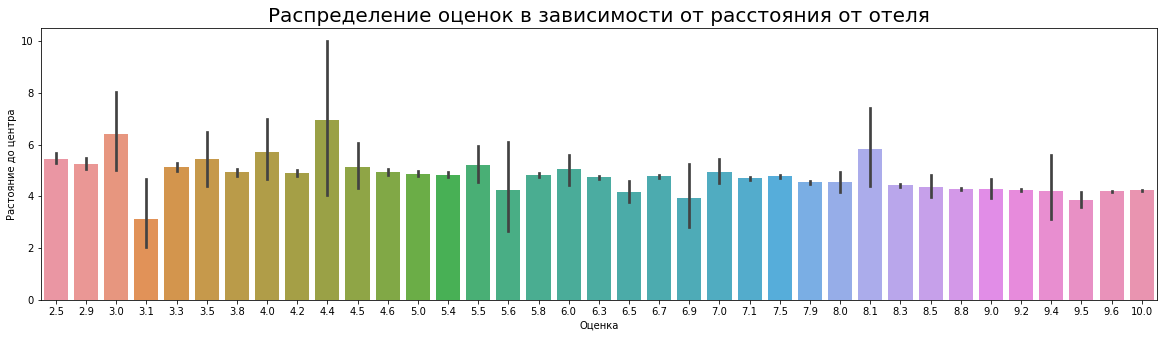

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

barplot = sns.barplot(
    data = data[data['sample'] == 1],
    x = 'reviewer_score',
    y = 'hotel_distance_to_center'
)
barplot.set_title('Распределение оцeнок в зависимости от расстояния от отеля', size = 20);
barplot.set_xlabel('Оценка');
barplot.set_ylabel('Растояние до центра');

В графике можно заметить тенденцию, что оценка растет с уменьшением растояния до центра. Однако наблюдаются оценки не попадающие под тенденцию. Например оценка 3,1 соответствует растоянию 3 км. Что ближе к центру, чем с оценкой 10. 

# Выделим из даты отзыва данные

In [27]:
data['review_date']= pd.to_datetime(data['review_date'])
data['year of review'] = data['review_date'].dt.year
data['month of review'] = data['review_date'].dt.month
data['day of review'] = data['review_date'].dt.day
data['weekday of review'] = data['review_date'].dt.dayofweek
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,city_3,city_4,city_5,city_6,hotel_distance_to_center,hotel_distance_to_center_round,year of review,month of review,day of review,weekday of review
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,0,7.837768,7.8,2017,7,21,4
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0,0,0,6.243807,6.2,2016,12,12,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,1,0,0,0,0.563942,0.6,2015,11,26,3
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,0,0,0,0,1.873428,1.9,2015,10,17,5
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,2016-05-16,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,0,0,0,0,0.403517,0.4,2016,5,16,0


In [28]:
#Добавим колонку с датой в список для удаления
data_drop.append('review_date')

In [29]:
# Также у нас есть признак days_since_review который можно перевести в числовой удалив слова day и days.
# И сразу поменяем тип данных с int.
data['days_since_review'] = data['days_since_review'].str.split().str[0]
data['days_since_review'] = data['days_since_review'].astype('int')

In [30]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,city_3,city_4,city_5,city_6,hotel_distance_to_center,hotel_distance_to_center_round,year of review,month of review,day of review,weekday of review
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,0,7.837768,7.8,2017,7,21,4
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0,0,0,6.243807,6.2,2016,12,12,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,1,0,0,0,0.563942,0.6,2015,11,26,3
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,0,0,0,0,1.873428,1.9,2015,10,17,5
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,2016-05-16,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,0,0,0,0,0.403517,0.4,2016,5,16,0


# Посмотрим зависит ли оценка от месяца и дня недели

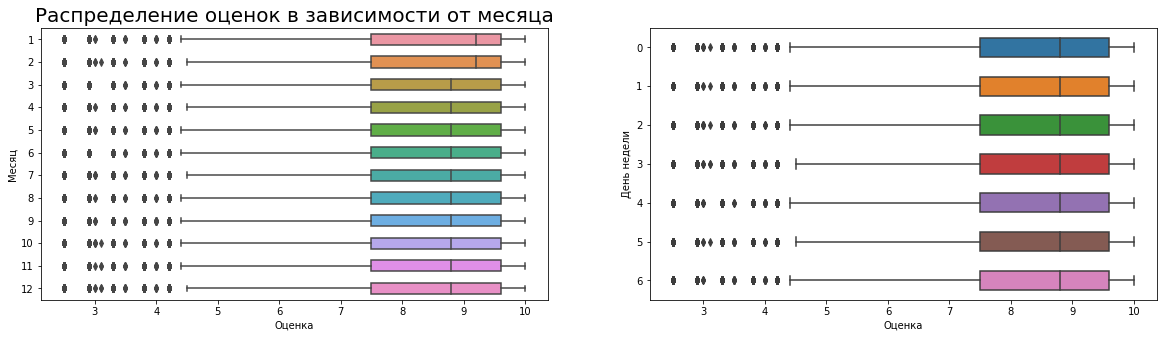

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

boxplot = sns.boxplot(
    data = data[data['sample'] == 1],
    y = 'month of review',
    x = 'reviewer_score',
    orient ='h',
    width = 0.5,
    ax=axes[0]
   )
boxplot.set_title('Распределение оценок в зависимости от месяца', size = 20);
boxplot.set_xlabel('Оценка');
boxplot.set_ylabel('Месяц');

boxplot = sns.boxplot(
    data = data[data['sample'] == 1],
    y = 'weekday of review',
    x = 'reviewer_score',
    orient ='h',
    width = 0.5,
    ax=axes[1]
   )

boxplot.set_xlabel('Оценка');
boxplot.set_ylabel('День недели');


Из графиков видно, что сезон влияет на оценку. Хотя диапазон популярных оценок не меняется по месяцам. Медиана в январе и феврале выше, чем в остальных месяцах. День недели не оказал влияния на оценку.

# Определим каки отели наиболее популярные

In [32]:
data['hotel_name'].value_counts(normalize = True)

Britannia International Hotel Canary Wharf           0.009286
Strand Palace Hotel                                  0.008252
Park Plaza Westminster Bridge London                 0.008084
Copthorne Tara Hotel London Kensington               0.006938
DoubleTree by Hilton Hotel London Tower of London    0.006228
                                                       ...   
Hotel Eitlj rg                                       0.000023
Hotel Daniel Paris                                   0.000023
Mercure Paris Porte d Orleans                        0.000019
Hotel Wagner                                         0.000019
Hotel Gallitzinberg                                  0.000016
Name: hotel_name, Length: 1492, dtype: float64

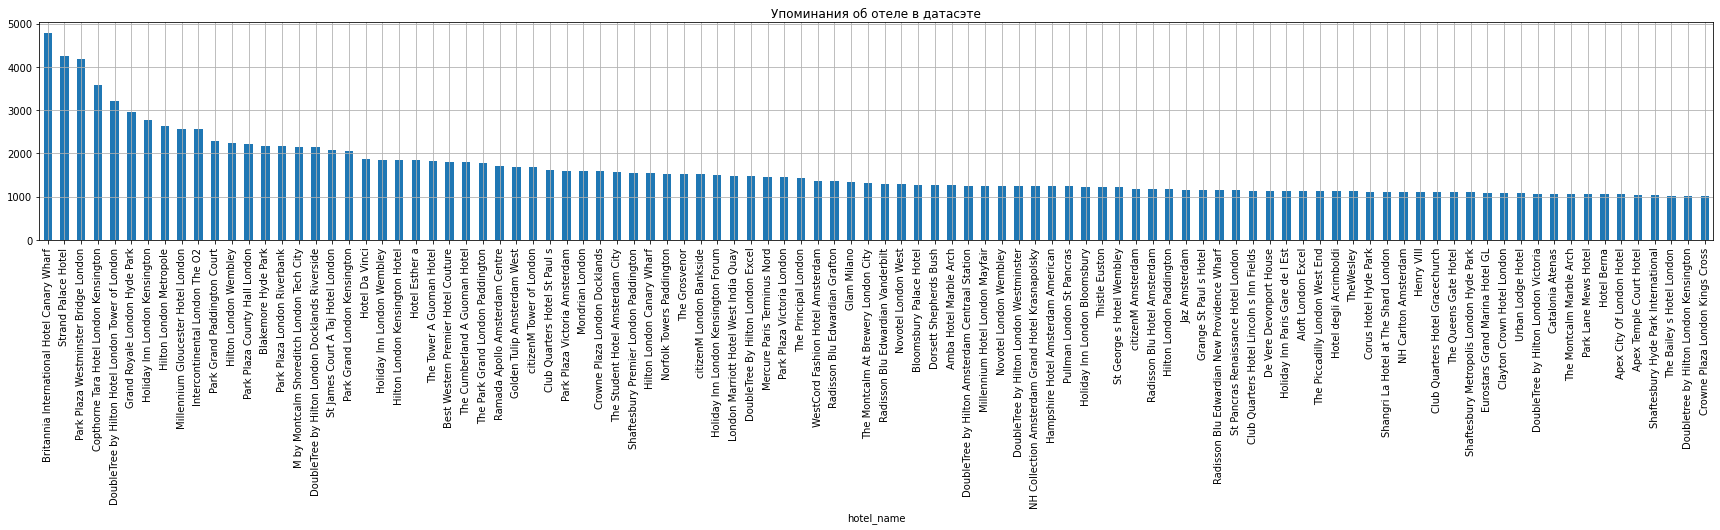

In [33]:
grouped_hotels = data.groupby(['hotel_name'])['hotel_name'].count()
grouped_hotels = grouped_hotels.nlargest(100) #Выведем информацию о 100 чаще встречающихся отелях
grouped_hotels.plot(
    grid=True,
    kind='bar',
    figsize=(30, 4),
    title='Упоминания об отеле в датасэте'
);

In [34]:
#Определим из каких стран туристы оставляли отзывы
data['reviewer_nationality'].value_counts()

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

In [35]:
#Всего в датасете отзывы от туристов из 227 стран

In [36]:
# Закодируем признак reviewer_nationality
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)
data.drop(['reviewer_nationality'],axis=1,inplace=True)

# Поработаем с тегами

In [37]:
data['tags'].value_counts()

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                   5101
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                          4931
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                          4366
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                            3991
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                                                  3291
                                                                                                                                                          ... 
[' Leisure trip ', ' Couple ', ' Superior Quee

In [38]:
#Из тегов выясним, на сколько ночей останавливаются путешественники в отелях.
def get_nights(tags):
    tags_list2 = tags.split(' ')
    night_list = ['nights','night']
    nights = 0
    for i in range(len(tags_list2)):
        if tags_list2[i] in night_list:
            nights = tags_list2[i-1]
    return int(nights)

data['nights'] = data['tags'].apply(get_nights)
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,weekday of review,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,nights
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,4,0,0,0,0,0,0,0,1,2
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,0,0,0,0,0,1,0,1


# Посмотрим зависит ли оценка от количества ночей

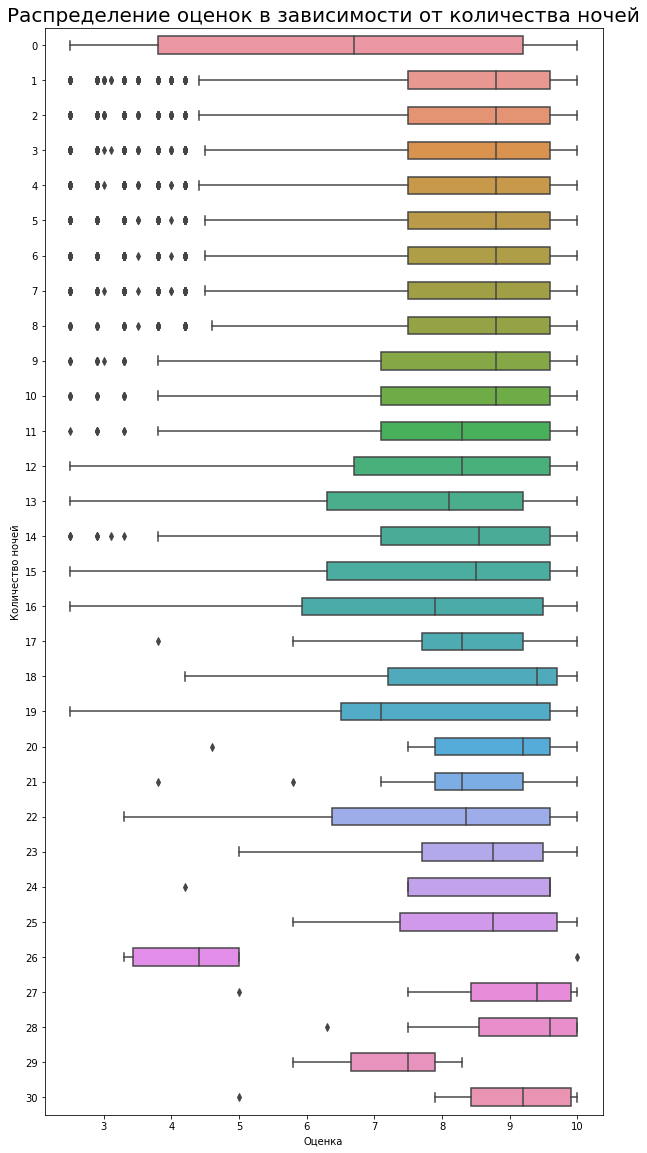

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 20))

boxplot = sns.boxplot(
    data = data[data['sample'] == 1],
    y = 'nights',
    x = 'reviewer_score',
    orient ='h',
    width = 0.5
)
boxplot.set_title('Распределение оценок в зависимости от количества ночей', size = 20);
boxplot.set_xlabel('Оценка');
boxplot.set_ylabel('Количество ночей');

До 8 ночей оценки идентичные. Чем больше ночей, тем больше разброс в оценках, что может быть вызвано малым количеством наблюдений.

In [40]:
#Из тегов выясним, причину путешествия.
def get_reason_of_trip(tags):
    tags_list2 = tags.split(' ')
    reason_list = ['trip']
    reason_of_trip = 0
    for i in range(len(tags_list2)):
        if tags_list2[i] in reason_list:
            reason_of_trip = tags_list2[i-1]
    return reason_of_trip

data['reason_of_trip'] = data['tags'].apply(get_reason_of_trip)
data['reason_of_trip'].value_counts()

Leisure     417778
Business     82939
0            15021
Name: reason_of_trip, dtype: int64

In [41]:
#Закодируем причины
encoder = ce.OneHotEncoder(cols=['reason_of_trip']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['reason_of_trip'])
data = pd.concat([data, type_bin], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 50 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   negative_review                             515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

In [42]:
#Добавим колонку с причиной в список на удаление
data_drop.append('reason_of_trip')

In [43]:
#Из тегов выясним, состав путешествующих.
def get_type_of_travalers(tags):    
    tags_list2 = tags.split(' ')
    travalers_list = ['Solo','Couple','Family']
    type_of_travalers = 0
    for i in range(len(tags_list2)):
        if tags_list2[i] in travalers_list:
            type_of_travalers = tags_list2[i]
    return type_of_travalers

data['type_of_travalers'] = data['tags'].apply(get_type_of_travalers)
data['type_of_travalers'].value_counts()

Couple    251636
Solo      108246
Family     89399
0          66457
Name: type_of_travalers, dtype: int64

# Посмотрим зависит ли оценка от состава путешествующих

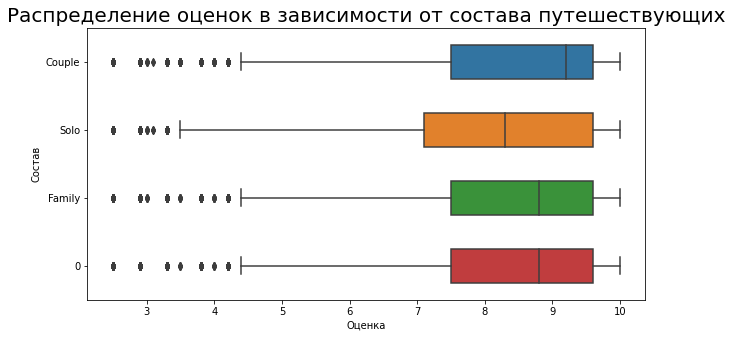

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

boxplot = sns.boxplot(
    data = data[data['sample'] == 1],
    y = 'type_of_travalers',
    x = 'reviewer_score',
    orient ='h',
    width = 0.5
)
boxplot.set_title('Распределение оценок в зависимости от состава путешествующих', size = 20);
boxplot.set_xlabel('Оценка');
boxplot.set_ylabel('Состав');

Самый большой разброс оценок наблюдается у путешествующих в одиночку. Самая высокая медиана наблюдается у пар.

In [45]:
#Закодируем состав путешествующих
encoder = ce.OneHotEncoder(cols=['type_of_travalers']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['type_of_travalers'])
data = pd.concat([data, type_bin], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   negative_review                             515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

In [46]:
#Удалим колонку с составом путешествующих
data.drop(columns = 'type_of_travalers', inplace = True)

In [47]:
#Из тегов выясним, есть ли маленькие дети.
def get_young_children(tags):    
    tags_list2 = tags.split(' ')
    young_children_list = ['young','baby','babies']
    young_children = 0
    for i in range(len(tags_list2)):
        if tags_list2[i] in young_children_list:
            young_children = 1
    return young_children
  
data['young_children'] = data['tags'].apply(get_young_children)
data['young_children'].value_counts()

0    454723
1     61015
Name: young_children, dtype: int64

In [48]:
#Из тегов выясним, есть ли взрослые дети.
def get_older_children(tags):    
    tags_list2 = tags.split(' ')
    older_children_list = ['older']
    older_children = 0
    for i in range(len(tags_list2)):
        if tags_list2[i] in older_children_list:
            older_children = 1
    return older_children 

data['older_children'] = data['tags'].apply(get_older_children)
data['older_children'].value_counts()

0    489389
1     26349
Name: older_children, dtype: int64

In [49]:
#Из тегов выясним количество комнат.
def get_count_of_room(tags):    
    tags_list2 = tags.split(' ')
    count_of_room = 0
    if 'Single' in tags:
        count_of_room = 1
    elif ('Double' or 'Twin' or 'Duplex') in tags:
        count_of_room = 2
    elif 'Triple' in tags:
        count_of_room = 3
    else: count_of_room = 'other'
    return count_of_room

data['count_of_room'] = data['tags'].apply(get_count_of_room)
data['count_of_room'].value_counts()



2        300983
other    178030
1         27140
3          9585
Name: count_of_room, dtype: int64

Выделение количествав комнат, не очень показательно, так как значительное количество попало в категорию "other".

In [50]:
#Закодируем количество комнат
encoder = ce.OneHotEncoder(cols=['count_of_room']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['count_of_room'])
data = pd.concat([data, type_bin], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 61 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   negative_review                             515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

In [51]:
#Добавим колонку с составом путешествующих в список на удаление
data_drop.append('count_of_room')

In [52]:
#Добавим колонку tags  в список на удаление
data_drop.append('tags')

# Обработаем отзывы

In [53]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Первым делов подправим явные выражения 
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('All good', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
data['positive_review'] = data['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

data['neg_scores'] = data['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
data['pos_scores'] = data['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
data['n_review_sentiments_neg'] = data['neg_scores'].apply(lambda x: x['neg'])
data['n_review_sentiments_neu'] = data['neg_scores'].apply(lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['neg_scores'].apply(lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['neg_scores'].apply(lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['pos_scores'].apply(lambda x: x['neg'])
data['p_review_sentiments_neu'] = data['pos_scores'].apply(lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['pos_scores'].apply(lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['pos_scores'].apply(lambda x: x['compound'])

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 71 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   negative_review                             515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

In [55]:
data_drop.extend(['negative_review', 'positive_review'])

Наиболее высокая корреляция между признаками:


,level_0,level_1,0
1134,city_3,country_3,1.000000
966,country_6,city_6,1.000000
1014,city_1,country_1,1.000000
1074,city_2,country_2,1.000000
1194,city_4,country_4,1.000000
1254,city_5,country_5,1.000000
1381,hotel_distance_to_center,hotel_distance_to_center_round,0.999976
3121,n_review_sentiments_neu,n_review_sentiments_pos,0.940379
599,reviewer_score,sample,0.931753
1481,year of review,days_since_review,0.917266


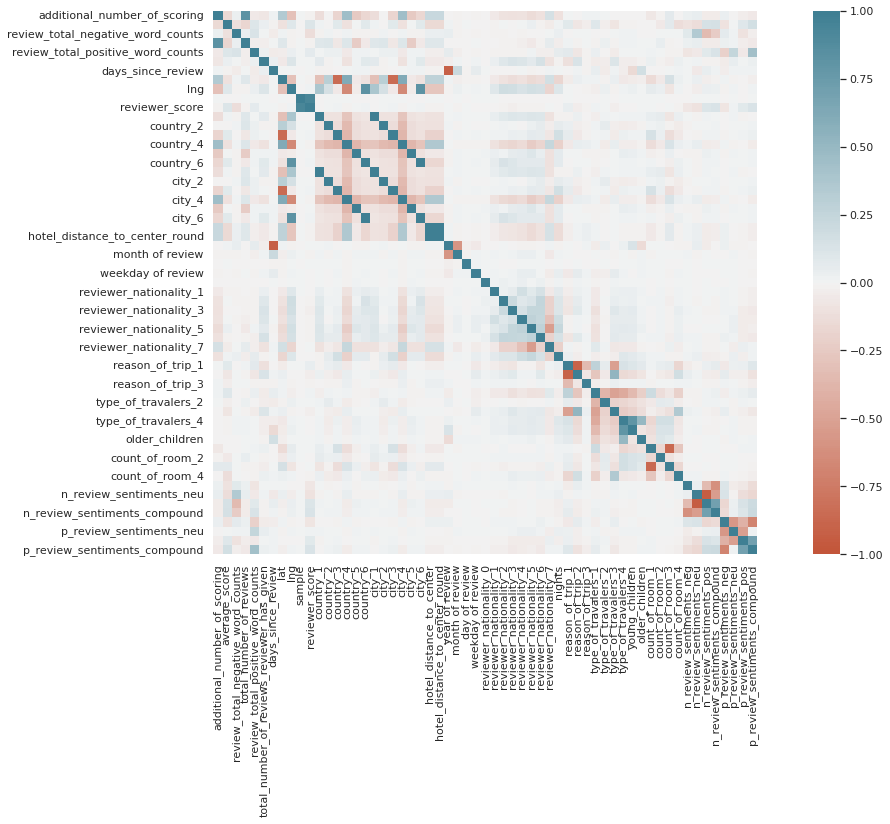

In [56]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = data.corr()
sns.set(rc={'figure.figsize':(20, 10)})
ax = sns.heatmap(
    corr, 
    vmin=-1, 
    vmax=1, 
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
);
print('Наиболее высокая корреляция между признаками:')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.sort_values(by=[0], ascending=False)
mask = corr_unstack['level_0'] != corr_unstack['level_1']
corr_unstack = corr_unstack[mask]
corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
corr_unstack = corr_unstack.drop(['pr1'], axis=1)
corr_unstack.iloc[:20, :]

In [57]:
#Удалим признаки с корреляцией больше 0.75
data.drop(columns = ['city_1', 'city_2','city_3', 'city_4', 'city_5', 'city_6', 'days_since_review','n_review_sentiments_neu', 'days_since_review', 'lat', 'lng', 'total_number_of_reviews'], inplace = True)

Наиболее высокая корреляция между признаками:


,level_0,level_1,0
638,hotel_distance_to_center,hotel_distance_to_center_round,0.999976
293,reviewer_score,sample,0.931753
1420,reason_of_trip_2,reason_of_trip_1,0.904034
1815,count_of_room_1,count_of_room_3,0.859558
1667,type_of_travalers_4,young_children,0.799937
2302,p_review_sentiments_compound,p_review_sentiments_pos,0.698729
2059,n_review_sentiments_pos,n_review_sentiments_compound,0.697847
2300,p_review_sentiments_compound,p_review_sentiments_neg,0.690591
2011,n_review_sentiments_neg,n_review_sentiments_compound,0.613093
736,year of review,month of review,0.581331


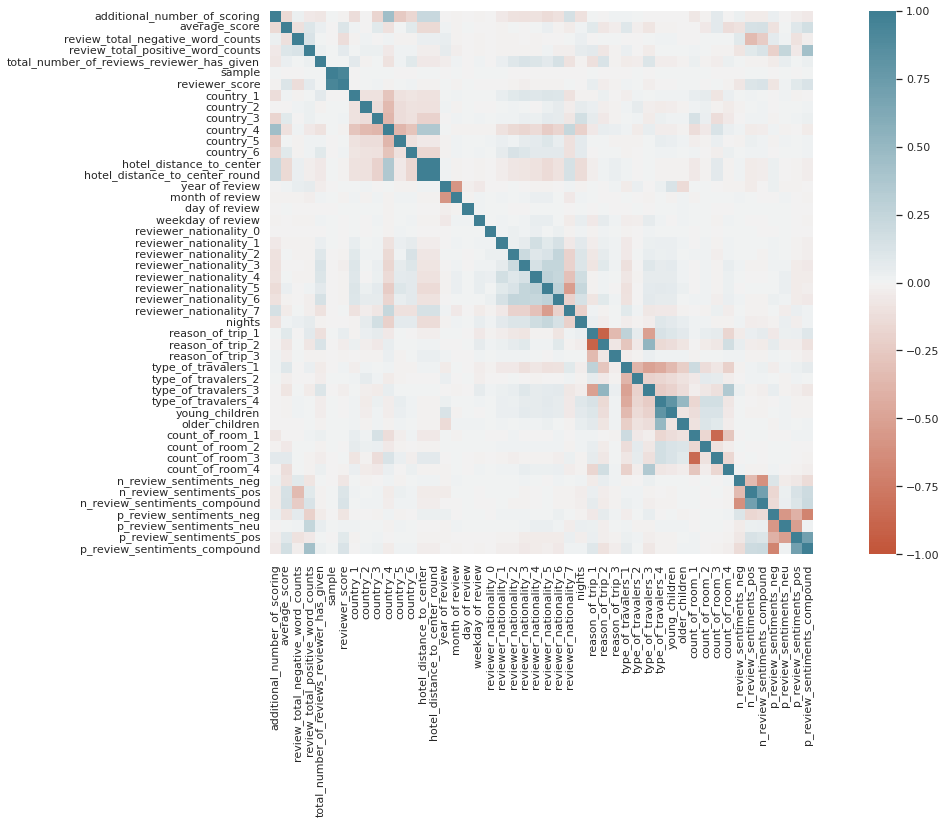

In [58]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = data.corr()
sns.set(rc={'figure.figsize':(20, 10)})
ax = sns.heatmap(
    corr, 
    vmin=-1, 
    vmax=1, 
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
);
print('Наиболее высокая корреляция между признаками:')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.sort_values(by=[0], ascending=False)
mask = corr_unstack['level_0'] != corr_unstack['level_1']
corr_unstack = corr_unstack[mask]
corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
corr_unstack = corr_unstack.drop(['pr1'], axis=1)
corr_unstack.iloc[:20, :]

In [59]:
data_drop

['country',
 'city',
 'hotel_distance_to_center',
 'review_date',
 'reason_of_trip',
 'count_of_room',
 'tags',
 'negative_review',
 'positive_review']

In [60]:
# убираем признаки из списка
data.drop(data_drop, axis = 1, inplace=True)


In [61]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 47 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   sample                                      515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   country_1                                   515738 non-null  int64  
 8   country_2                                   515738 non-null  int64  
 9   country_3                                   515738 non-null  int64  
 

In [63]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [64]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [65]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 46), (386803, 46), (386803, 45), (309442, 45), (77361, 45))

In [66]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [67]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [68]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


In [69]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8784792065769571


<AxesSubplot:>

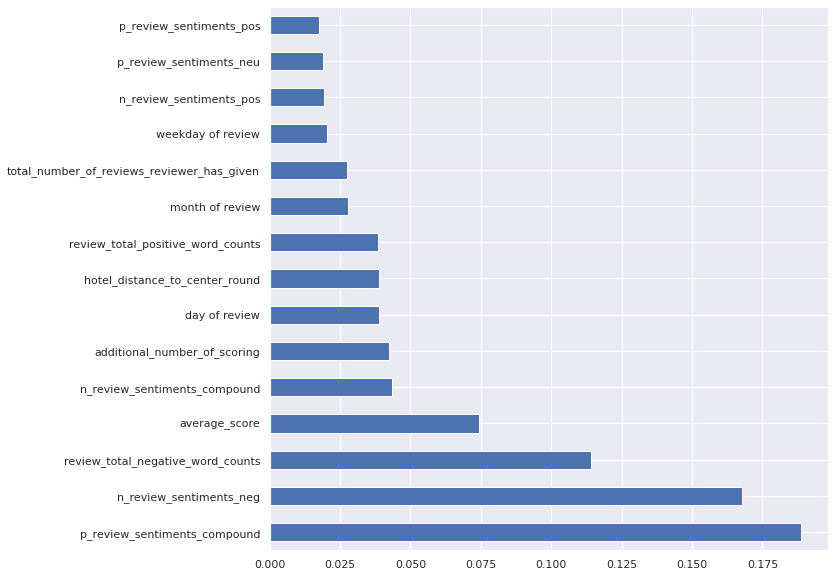

In [70]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [71]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,country_1,country_2,country_3,country_4,...,count_of_room_2,count_of_room_3,count_of_room_4,n_review_sentiments_neg,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound
110261,114,8.3,2,3,7,0.0,0,0,0,0,...,0,0,0,0.000,0.000,0.0000,0.0,1.000,0.000,0.0000
16982,16,8.4,0,15,49,0.0,0,0,0,0,...,0,0,0,0.000,1.000,0.5574,0.0,0.667,0.333,0.7184
91598,397,8.3,0,3,2,0.0,0,0,0,1,...,0,0,0,0.000,1.000,0.5574,0.0,1.000,0.000,0.0000
110483,438,7.4,31,29,10,0.0,0,0,0,1,...,0,0,0,0.000,0.000,0.0000,0.0,0.571,0.429,0.9409
12980,457,6.8,12,2,4,0.0,0,0,0,1,...,0,0,1,0.198,0.000,-0.2449,0.0,1.000,0.000,0.0000
61312,185,8.8,10,0,9,0.0,0,0,1,0,...,0,0,0,0.318,0.000,-0.4215,1.0,0.000,0.000,-0.5719
85488,434,8.6,6,13,1,0.0,0,0,1,0,...,0,0,0,0.420,0.000,-0.4404,0.0,0.606,0.394,0.7050
36375,224,7.7,6,0,1,0.0,0,1,0,0,...,0,0,0,0.310,0.000,-0.2023,1.0,0.000,0.000,-0.5719
91748,155,9.4,3,9,2,0.0,0,0,0,0,...,0,0,0,0.000,0.000,0.0000,0.0,0.431,0.569,0.7650
58696,158,8.4,9,13,9,0.0,0,0,1,0,...,0,0,0,0.000,0.295,0.2724,0.0,0.353,0.647,0.9001


In [72]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [73]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [74]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


In [75]:
predict_submission

array([8.488, 7.488, 8.707, ..., 8.216, 9.516, 7.175])

In [76]:
list(sample_submission)

['reviewer_score', 'id']

In [77]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.488,488440
1,7.488,274649
2,8.707,374688
3,9.791,404352
4,9.526,451596
5,9.005,302161
6,7.199,317079
7,7.539,13963
8,8.480,159785
9,7.404,195089
